In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay,classification_report
from sklearn.metrics import confusion_matrix, make_scorer, RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.classifier import ConfusionMatrix
from pandas.plotting import scatter_matrix
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_selection import SelectPercentile, SelectFromModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [2]:
data = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv')

In [3]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# 1. Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


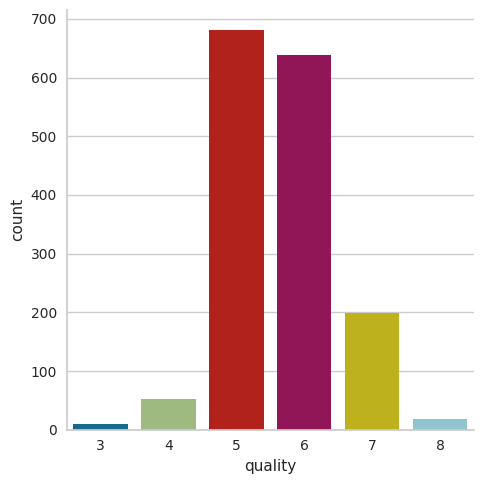

In [4]:
sns.catplot(x = 'quality', data = data , kind = 'count',margin_titles = True)

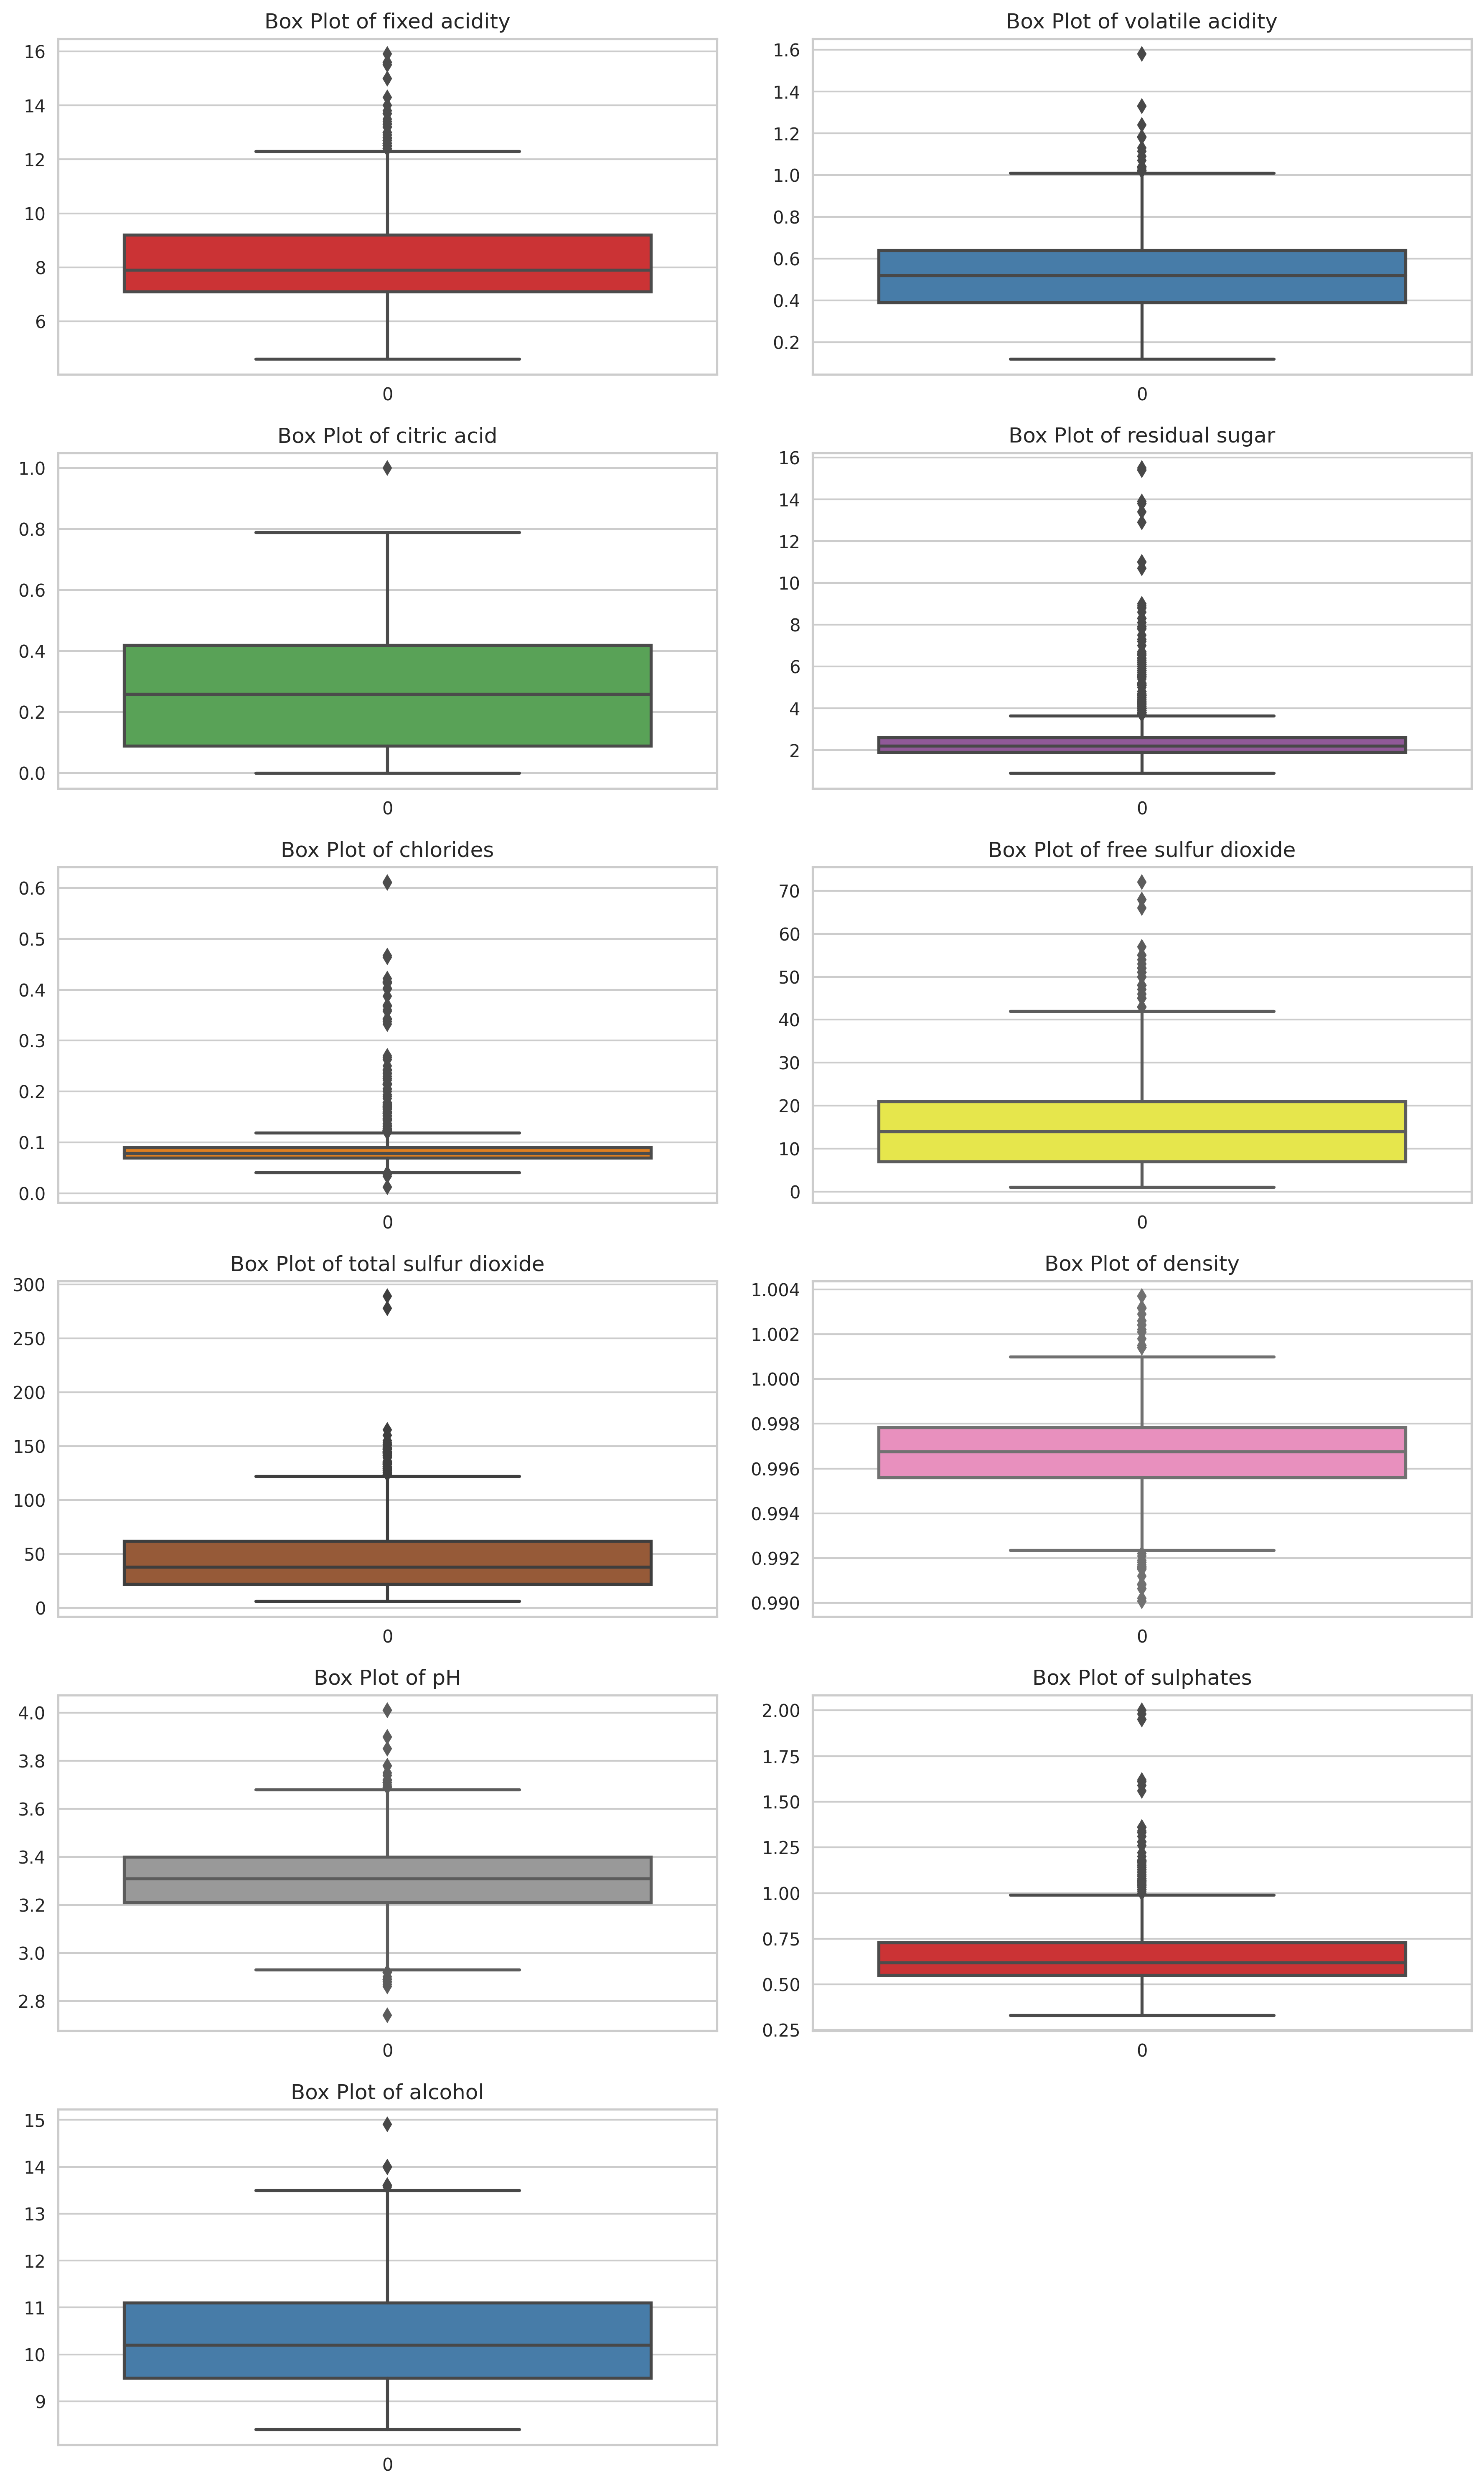

In [5]:
features = data.columns.drop('quality')
columns = features.values
num_columns = len(columns)
num_rows = (num_columns + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(12, 20),dpi = 300)

colors = sns.color_palette("Set1", num_columns)
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    sns.boxplot(data=data[column], ax=axes[row, col], color=colors[i])
    axes[row, col].set_title(f'Box Plot of {column}')

if num_columns % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()



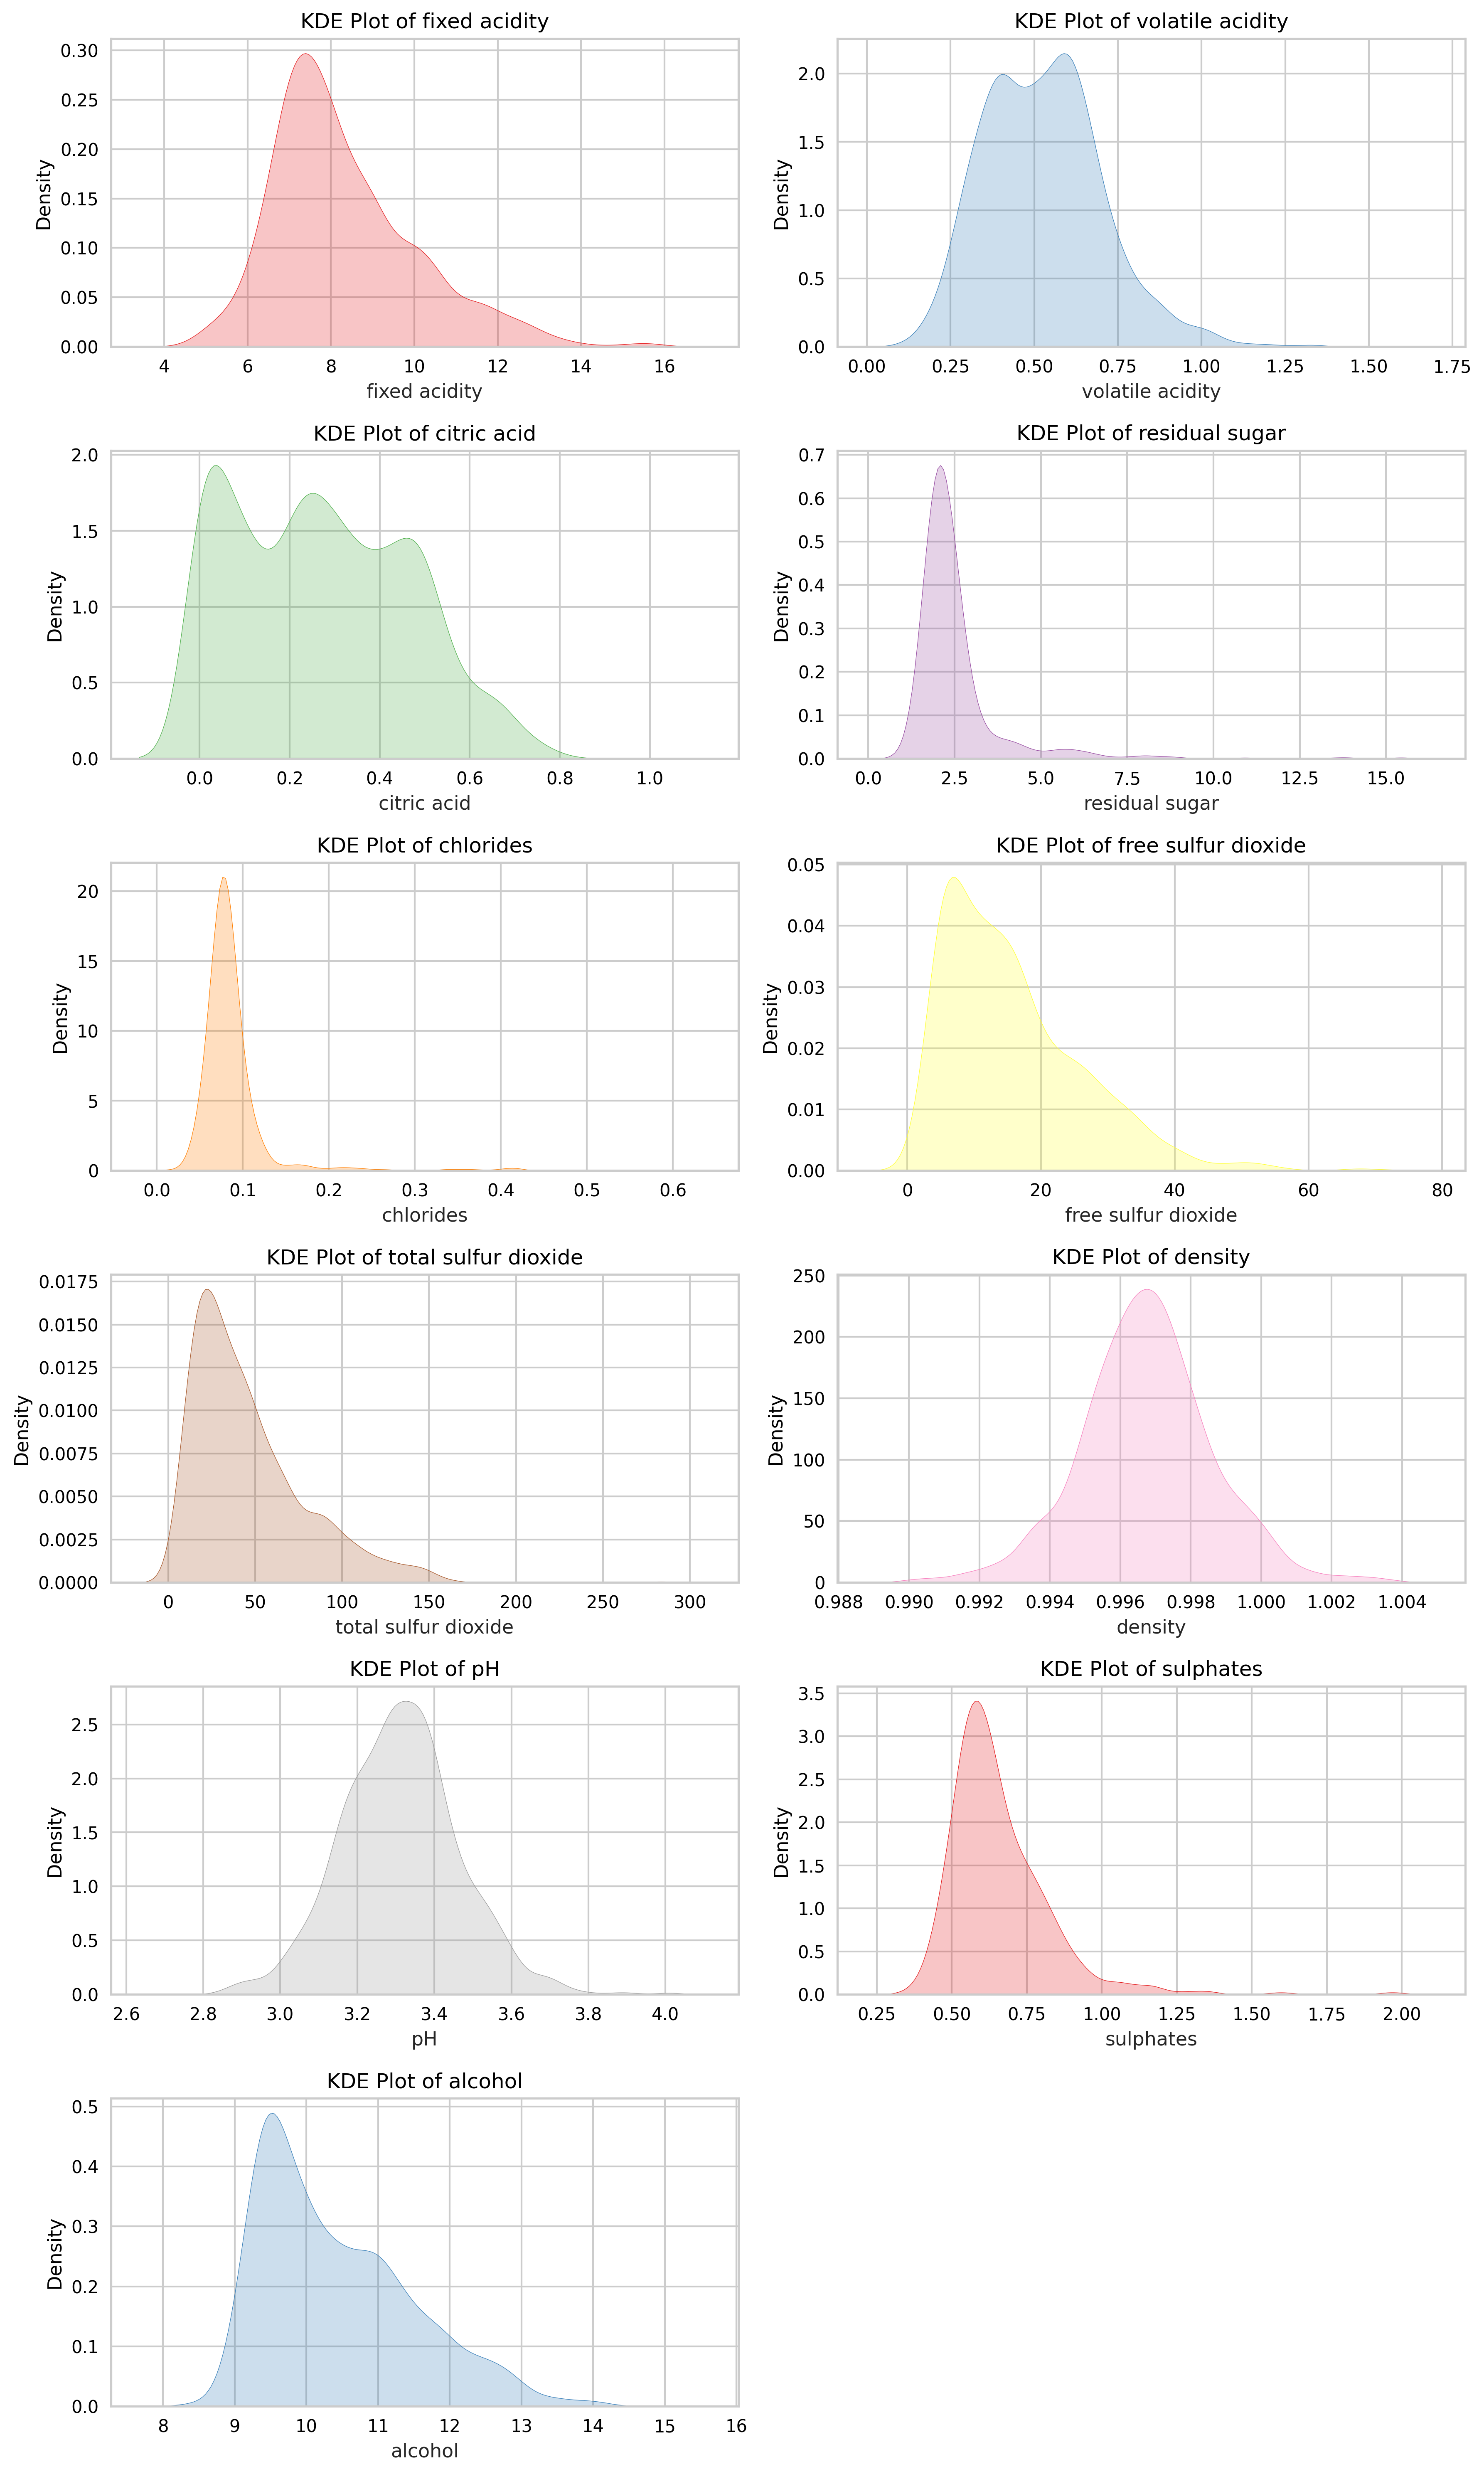

In [6]:
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 20), dpi=300)
label_color = 'black'
title_color = 'black'
for i, column in enumerate(columns):
    row = i // 2
    col = i % 2
    
    sns.kdeplot(data=data[column], ax=axes[row, col], color=colors[i], fill=True, legend=False)
    axes[row, col].set_ylabel('Density', color=label_color)
    axes[row, col].yaxis.label.set_color(label_color)
    axes[row, col].set_title(f'KDE Plot of {column}', color=title_color)
    
    axes[row, col].tick_params(axis='x', colors=label_color)
    axes[row, col].tick_params(axis='y', colors=label_color)
    axes[row, col].title.set_color(title_color)
    axes[row, col].grid(True)
    
    fig.subplots_adjust(wspace=0.4)

if num_columns % 2 != 0:
    axes[-1, -1].axis('off')

plt.tight_layout()
plt.show()

# 2. Data Information

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [8]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


# 3. Data Cleaning

In [9]:
duplicated = data[data.duplicated()]
duplicated

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [10]:
data.drop_duplicates()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
5,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1593,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# 4. Feature Selection

In [11]:
bins = (2, 6.5, 8)
cat = ['bad', 'good']
data.quality = pd.cut(data.quality, bins = bins, labels = cat)

In [12]:
label_quality = LabelEncoder()
data.quality = label_quality.fit_transform(data.quality)

In [13]:
data.quality.value_counts()

quality
0    1382
1     217
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


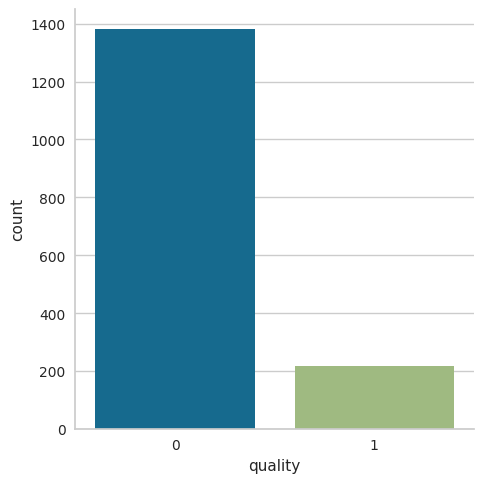

In [14]:
sns.catplot(x = 'quality', data = data , kind = 'count',margin_titles = True)

In [15]:
features = data.columns.drop('quality')

In [16]:
X = data[features]
y = data['quality']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
def Percentile_Capping(columns, x_train, y_train, a, b):
    
    outliers=[]
    for col in columns:
        q1=np.percentile(x_train[col], a)
        q2=np.percentile(x_train[col], b)
    
    for i in range(len(x_train)):
        if x_train[col].iloc[i]>q2 or  x_train[col].iloc[i]<q1:
            outliers.append(i)
            
    outliers=set(outliers)    # to remove the duplicate values in the dataset
    outliers=list(outliers)
            
            
    x_train.drop(x_train.index[outliers], inplace=True)   # remove the outliers from the trainin data
    y_train.drop(y_train.index[outliers], inplace=True)
            
    ratio= round(len(outliers)/len(x_train)*100,2)
            
            
    return x_train, y_train, ratio

In [19]:
X_train, y_train, ratio= Percentile_Capping(X_train.columns, X_train, y_train, a=2, b=98)

In [20]:
X_train.shape, y_train.shape

((1255, 11), (1255,))

In [21]:
print(f"Ratio of outliers in the dataset:{ratio}")

Ratio of outliers in the dataset:1.91


In [22]:
scaler = MinMaxScaler()

In [23]:
X_train_tr = scaler.fit_transform(X_train)
X_test_tr = scaler.fit_transform(X_test)

# 5. Decision Tree

In [24]:
hyperparameters = [{
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10]
}]

dt = DecisionTreeClassifier()
grid_search = GridSearchCV(dt, hyperparameters, scoring='f1_micro', cv=5, verbose=True, n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
best_dt_params = grid_search.best_params_

Fitting 5 folds for each of 96 candidates, totalling 480 fits


In [25]:
print(best_dt_params)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [26]:
best_dt = DecisionTreeClassifier(**best_dt_params)
best_dt.fit(X_train_tr, y_train.ravel())
y_pred_dt = best_dt.predict(X_test_tr)

In [27]:
f1 = f1_score(y_test, y_pred_dt, average='micro')
print("F1 Score on Test Set:", f1)

F1 Score on Test Set: 0.840625


In [28]:
print("Accuracy:", accuracy_score(y_test,y_pred_dt))
y_pred_dt_train = best_dt.predict(X_train_tr)
print("Accuracy on train:", accuracy_score(y_train,y_pred_dt_train))

Accuracy: 0.840625
Accuracy on train: 0.9179282868525896


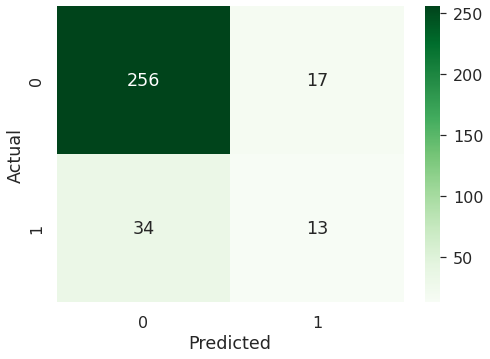

In [29]:
dt_cm = confusion_matrix(y_test, y_pred_dt)
sns.set(font_scale=1.5)
plt.figure(dpi=70)
sns.heatmap(dt_cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 6. Logistic Regression

In [30]:
lr_params = [{'C': [0.1, 1, 10]}]
lr = LogisticRegression()
lr_grid_search = GridSearchCV(lr, lr_params, scoring='f1_micro', cv=5, verbose=True, n_jobs=-1)
lr_grid_search.fit(X_train_tr, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10]}], scoring='f1_micro',
             verbose=True)

In [31]:
best_lr_params = lr_grid_search.best_params_
print(best_lr_params)

{'C': 10}


In [32]:
best_lr = LogisticRegression(**best_lr_params)
best_lr.fit(X_train_tr, y_train)
y_pred_lr = best_lr.predict(X_test_tr)

In [33]:
f1_lr = f1_score(y_test, y_pred_lr, average='micro')
print("F1 Score on Test Set (Logistic Regression):", f1_lr)

F1 Score on Test Set (Logistic Regression): 0.859375


In [34]:
print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_lr))
y_pred_lr_train = best_lr.predict(X_train_tr)
print("Accuracy on train (Logistic Regression):", accuracy_score(y_train, y_pred_lr_train))

Accuracy (Logistic Regression): 0.859375
Accuracy on train (Logistic Regression): 0.8916334661354581


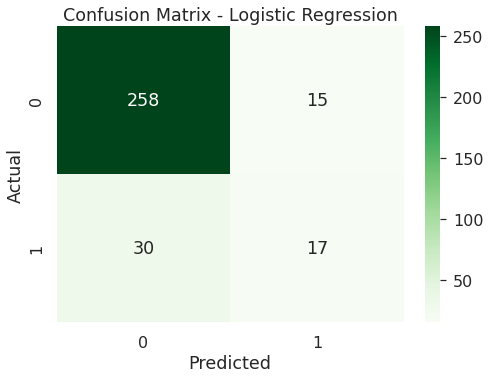

In [35]:
lr_cm = confusion_matrix(y_test, y_pred_lr)
plt.figure(dpi=70)
sns.heatmap(lr_cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# 7. Support Vector Machines

In [36]:
svm_params = [{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}]
svm = SVC()
svm_grid_search = GridSearchCV(svm, svm_params, scoring='f1_micro', cv=5, verbose=True, n_jobs=-1)
svm_grid_search.fit(X_train_tr, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid=[{'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}],
             scoring='f1_micro', verbose=True)

In [37]:
best_svm_params = svm_grid_search.best_params_
print(best_svm_params)

{'C': 1, 'kernel': 'rbf'}


In [38]:
best_svm = SVC(**best_svm_params)
best_svm.fit(X_train_tr, y_train)
y_pred_svm = best_svm.predict(X_test_tr)

In [39]:
f1_svm = f1_score(y_test, y_pred_svm, average='micro')
print("F1 Score on Test Set (SVM):", f1_svm)

F1 Score on Test Set (SVM): 0.865625


In [40]:
print("Accuracy (SVM):", accuracy_score(y_test, y_pred_svm))
y_pred_svm_train = best_svm.predict(X_train_tr)
print("Accuracy on train (SVM):", accuracy_score(y_train, y_pred_svm_train))

Accuracy (SVM): 0.865625
Accuracy on train (SVM): 0.8980079681274901


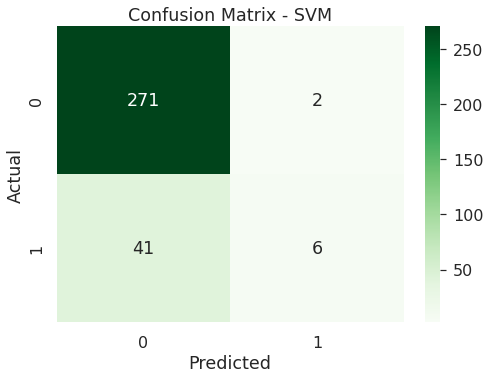

In [41]:
svm_cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(dpi=70)
sns.heatmap(svm_cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - SVM')
plt.show()

# 8. K-Nearest Neighbors

In [42]:
hyperparameters = [{
    'n_neighbors': range(3,21,2),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}]

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, hyperparameters, scoring='f1_micro', cv=5, verbose=True, n_jobs=-1)
grid_search.fit(X_train_tr, y_train)
best_knn_params = grid_search.best_params_;

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [43]:
print(best_knn_params)

{'n_neighbors': 19, 'p': 1, 'weights': 'distance'}


In [44]:
best_knn = KNeighborsClassifier(**best_knn_params)
best_knn.fit(X_train_tr, y_train.ravel())
y_pred_knn = best_knn.predict(X_test_tr)

In [45]:
print('F1 Score on test data : ', f1_score(y_test, best_knn.predict(X_test_tr), average='micro'))

F1 Score on test data :  0.86875


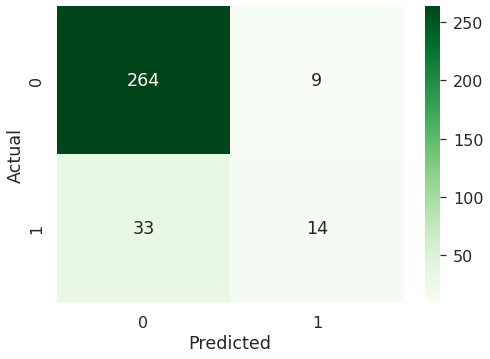

In [46]:
knn_cm = confusion_matrix(y_test, best_knn.predict(X_test_tr))
sns.set(font_scale=1.5)
plt.figure(dpi=70)
sns.heatmap(knn_cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 9. Random Forest

In [47]:
hyperparameters = [{
    'n_estimators': range(10,120,10),
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 5, 10],
    'max_features':[2,3,4]
}]

rf = RandomForestClassifier()
grid_search = GridSearchCV(rf, hyperparameters, scoring='f1_micro', cv=5, verbose=True, n_jobs=-1)
grid_search.fit(X_train_tr, y_train)

Fitting 5 folds for each of 198 candidates, totalling 990 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 5, 10], 'max_features': [2, 3, 4],
                          'n_estimators': range(10, 120, 10)}],
             scoring='f1_micro', verbose=True)

In [48]:
best_rf_params = grid_search.best_params_
print(best_rf_params)

{'criterion': 'entropy', 'max_depth': 10, 'max_features': 4, 'n_estimators': 100}


In [49]:
best_rf = RandomForestClassifier(**best_rf_params)
best_rf.fit(X_train_tr, y_train.ravel())
y_pred_rf = best_rf.predict(X_test_tr)

In [50]:
f1 = f1_score(y_test, y_pred_rf, average='micro')
print("F1 Score on Test Set:", f1)

F1 Score on Test Set: 0.871875


In [51]:
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
y_pred_rf_train = best_rf.predict(X_train_tr)
print("Accuracy on train:", accuracy_score(y_train, y_pred_rf_train))

Accuracy: 0.871875
Accuracy on train: 0.9952191235059761


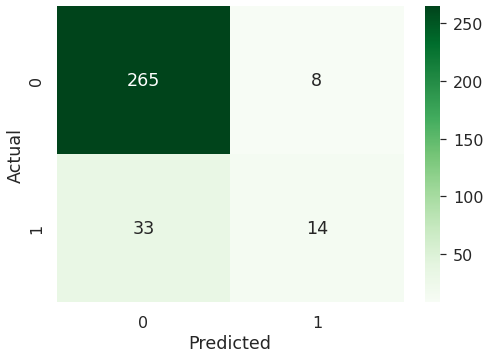

In [52]:
rf_cm = confusion_matrix(y_test, y_pred_rf)
sns.set(font_scale=1.5)
plt.figure(dpi=70)
sns.heatmap(rf_cm, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 10. Best model

In [53]:
accuracy_scores = {}

accuracy_scores['Random Forest'] = accuracy_score(y_test, y_pred_rf)
accuracy_scores['Decision Tree'] = accuracy_score(y_test, y_pred_dt)
accuracy_scores['K-Nearest Neighbors'] = accuracy_score(y_test, y_pred_knn)
accuracy_scores['Logistic Regression'] = accuracy_score(y_test, y_pred_lr)
accuracy_scores['SVM'] = accuracy_score(y_test, y_pred_svm)


best_method = max(accuracy_scores, key=accuracy_scores.get)
best_accuracy = accuracy_scores[best_method]

for method, accuracy in accuracy_scores.items():
    print(f"{method}: {accuracy}")

print(f"\nBest Method: {best_method}")
print(f"Accuracy: {best_accuracy}")

Random Forest: 0.871875
Decision Tree: 0.840625
K-Nearest Neighbors: 0.86875
Logistic Regression: 0.859375
SVM: 0.865625

Best Method: Random Forest
Accuracy: 0.871875


In [54]:
f1_scores = {}

f1_scores['Random Forest'] = f1_score(y_test, y_pred_rf, average='micro')
f1_scores['Decision Tree'] = f1_score(y_test, y_pred_dt, average='micro')
f1_scores['K-Nearest Neighbors'] = f1_score(y_test, y_pred_knn, average='micro')
f1_scores['Logistic Regression'] = f1_score(y_test, y_pred_lr, average='micro')
f1_scores['SVM'] = f1_score(y_test, y_pred_svm, average='micro')

best_method = max(f1_scores, key=f1_scores.get)
best_f1_score = f1_scores[best_method]

for method, f1 in f1_scores.items():
    print(f"{method}: {f1}")

print(f"\nBest Method: {best_method}")
print(f"Best F1 Score: {best_f1_score}")

Random Forest: 0.871875
Decision Tree: 0.840625
K-Nearest Neighbors: 0.86875
Logistic Regression: 0.859375
SVM: 0.865625

Best Method: Random Forest
Best F1 Score: 0.871875
